# 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import seaborn as sns
import folium
import datetime
import math

# 랜덤 시드 설정

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [3]:
_train_data = pd.read_csv('../../data/data/train.csv')
_test_data = pd.read_csv('../../data/data/test.csv')
sample_submission = pd.read_csv('../../data/data/sample_submission.csv')
subway_info = pd.read_csv('../../data/data/subwayInfo.csv')
school_info = pd.read_csv('../../data/data/schoolInfo.csv')
park_info = pd.read_csv('../../data/data/parkInfo.csv')
interest_rate = pd.read_csv('../../data/data/interestRate.csv')
_train_dist_data = pd.read_csv('../../data/data/train_dist.csv')
_test_dist_data = pd.read_csv('../../data/data/test_dist.csv')

# 데이터 전처리하기

In [482]:
# Train
train_data = _train_dist_data.copy()

# 음수 age를 양수로 변환
train_data["age"] = train_data["age"].abs()

# duplicated data 제거
dup_df = train_data[train_data.drop(columns="index").duplicated()]
train_data = train_data.drop(index=dup_df.index)

train_data.shape

(1717611, 18)

In [483]:
# Test
test_data = _test_dist_data.copy()

# 음수 age를 양수로 변환
test_data["age"] = test_data["age"].abs()

# 데이터 EDA 수행하기

In [236]:
print("train, test_data, sample_submission shape : ", train_data.shape, test_data.shape, sample_submission.shape)
# print("train data 상단 5개 정보 확인 : ", train_data.head())
# print("test data 상단 5개 정보 확인 : ", test_data.head())
print("sample_submission 상단 5개 정보 확인 : ", sample_submission.describe())
print("train data 변수 요약 정보 확인 : \n", train_data.describe())
print("train_dist_data 변수 요약 정보 확인 : \n", _train_dist_data.describe())
print("test data 변수 요약 정보 확인 : \n", test_data.describe())
print("subway_info 변수 요약 정보 확인 : \n", subway_info.describe())
print("school_info 변수 요약 정보 확인 : \n", school_info.describe())
print("park_info 변수 요약 정보 확인 : \n", park_info.describe())
print("interest_rate 변수 요약 정보 확인 : \n", interest_rate.describe())

train, test_data, sample_submission shape :  (1717611, 19) (150172, 17) (150172, 2)
sample_submission 상단 5개 정보 확인 :                index        deposit
count  150172.00000  150172.000000
mean    75085.50000   15580.683329
std     43351.06665   25223.002520
min         0.00000 -116185.289762
25%     37542.75000     506.251190
50%     75085.50000   14869.930405
75%    112628.25000   29647.136837
max    150171.00000  369326.498006
train data 변수 요약 정보 확인 : 
               index       area_m2  contract_year_month  contract_day  \
count  1.717611e+06  1.717611e+06         1.717611e+06  1.717611e+06   
mean   9.019509e+05  7.524180e+01         2.021336e+05  1.590339e+01   
min    0.000000e+00  1.032150e+01         2.019040e+05  1.000000e+00   
25%    4.534015e+05  5.975010e+01         2.020080e+05  9.000000e+00   
50%    9.022850e+05  7.792000e+01         2.021110e+05  1.600000e+01   
75%    1.351972e+06  8.496000e+01         2.022120e+05  2.300000e+01   
max    1.801227e+06  3.173600e+02    

# contract 날짜 feature 추가

In [484]:
# 필요 없는 column 제거
# train_data = train_data.drop(columns=["index"])
# test_data = test_data.drop(columns=["index"])

# year, month, date와 전체 일수인 contract_year_month_date로 변환
train_data['year'] = train_data['contract_year_month'] // 100
train_data['month'] = train_data['contract_year_month'] % 100
train_data.rename(columns={"contract_day": "date"}, inplace=True)
train_data["contract_year_month_date"] = train_data["year"]*365 + train_data["month"]*30 + train_data["date"]
train_data.drop(columns=["contract_year_month"], inplace=True)

test_data['year'] = test_data['contract_year_month'] // 100
test_data['month'] = test_data['contract_year_month'] % 100
test_data.rename(columns={"contract_day": "date"}, inplace=True)
test_data["contract_year_month_date"] = test_data["year"]*365 + test_data["month"]*30 + test_data["date"]
test_data.drop(columns=["contract_year_month"], inplace=True)

# contract_year_month_date를 기준으로 정렬
train_data = train_data.sort_values(by="contract_year_month_date")

# dist feature들은 제곱근 적용

In [ ]:
distance_columns = ['subway_distance', 'school_distance', 'park_distance']
train_data[distance_columns] = train_data[distance_columns].fillna(-1)

# 클러스터링

In [485]:
# Train
kmeans = KMeans(n_clusters=100, random_state=RANDOM_SEED)
train_data['cluster_100'] = kmeans.fit_predict(train_data[['latitude', 'longitude']])

# Test
test_data['cluster_100'] = kmeans.predict(test_data[['latitude', 'longitude']])

In [101]:
clusters = train_data[["cluster_100", "latitude", "longitude", "deposit"]].groupby("cluster_100").mean()

In [151]:
# 지도 생성 (초기 중심 좌표와 줌 레벨 설정)
m = folium.Map(location=[37.5665, 126.9780], zoom_start=12)  # 서울 좌표 예시

# norm으로 red의 채도 변화 후 hex값으로 저장
norm = (clusters["deposit"] - clusters["deposit"].min()) / (clusters["deposit"].max() - clusters["deposit"].min())
colors = [(mcolors.to_hex([1-c, 0.5-c/2, 1])) for c in norm]

# 지도에 마커 추가 (서울 위치에 마커 추가)
for index, (lat, lon, deposit) in enumerate(zip(clusters["latitude"], clusters["longitude"], clusters["deposit"])):
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,  # 원의 크기를 조정
        popup=deposit,
        color=colors[index],
        fill=True,
        fill_color=colors[index]
    ).add_to(m)
    
m

# 평당 가격 추가

In [486]:
train_data['deposit_per_area'] = train_data['deposit'] / train_data['area_m2']

# age에 따른 가중치 추가

In [489]:
# age에 따른 가중치 추가
train_conditions = [
    (train_data['age'] <= 5),   # 5년 이하
    (train_data['age'] <= 15),  # 15년 이하
    (train_data['age'] > 15)    # 15년 초과
]

test_conditions = [
    (test_data['age'] <= 5),   # 5년 이하
    (test_data['age'] <= 15),  # 15년 이하
    (test_data['age'] > 15)    # 15년 초과
]
weights = [3, 2, 1]  # 큰 가중치, 중간 가중치, 적은 가중치

train_data['age_weight'] = np.select(train_conditions, weights)
test_data['age_weight'] = np.select(test_conditions, weights)

# 아파트별 거래 시점 이전의 가장 최근 거래가

In [573]:
# Train
def get_previous_value(group):
    group['prev_deposit_per_area'] = group['deposit_per_area'].shift()  # 바로 이전 value 가져오기
    return group

# 같은 lat과 long의 데이터들 중에서 가장 가까운 이전 날짜의 행을 찾아 병합
train_df = train_data.groupby(['latitude', 'longitude']).apply(get_previous_value).reset_index(drop=True)

C:\Users\LHY\AppData\Local\Temp\ipykernel_4228\1696183696.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_data.groupby(['latitude', 'longitude']).apply(get_previous_value).reset_index(drop=True)


In [574]:
# Test
test_df_sorted = test_data.sort_values(by="contract_year_month_date")
train_df_sorted = train_data.sort_values(by="contract_year_month_date")

test_df = pd.merge_asof(
    test_df_sorted, train_df_sorted[["contract_year_month_date", "latitude", "longitude", "deposit_per_area"]],
    on='contract_year_month_date',  # 날짜를 기준으로 병합
    by=['latitude', 'longitude'],  # lat과 long이 같은 그룹에서
    direction='backward',  # test의 date보다 이전인 train의 가장 가까운 date를 선택
)

In [575]:
# Test에서 결측치는 train의 cluster_100의 deposit_per_area 평균값으로 대체
test_df['deposit_per_area'] = test_df['deposit_per_area'].fillna(train_df.groupby('cluster_100')['deposit_per_area'].transform('mean'))

# column 이름 변경
test_df.rename(columns={"deposit_per_area": "prev_deposit_per_area"}, inplace=True)

In [576]:
# Train에서는 결측치 있는 행 제거
train_df = train_df.dropna()

# Train을 contract_year_month_day 기준으로 재정렬
train_df = train_df.sort_values(by="contract_year_month_date")

# Test는 deposit과 deposit_per_area가 없으므로 2차이 나야함
train_df.shape, test_df.shape

((1699120, 24), (150172, 22))

### EDA

In [577]:
eda_df = train_data_filled.copy()
eda_df["apartment_id"] = eda_df.groupby(["latitude", "longitude"]).ngroup()
eda_df.drop(columns=["contract_year_month", "contract_day"], inplace=True)

In [390]:
eda_hist_df = eda_df.groupby("apartment_id").count().sort_values(by="deposit", ascending=False)

In [391]:
eda_hist_df.head(100)

,index,area_m2,contract_type,floor,built_year,latitude,longitude,age,deposit,nearest_subway_distance,nearest_subway_id,nearest_school_distance,nearest_school_id,nearest_park_distance,nearest_park_id,interest_rate,contract_year_month_day,cluster_100,deposit_per_area,prev_deposit_per_area
apartment_id,,,,,,,,,,,,,,,,,,,,
15694,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012
7800,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626,3626
9469,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108,3108
7810,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755,2755
8937,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645,2645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071
3453,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070
8929,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069


(0.0, 500.0)

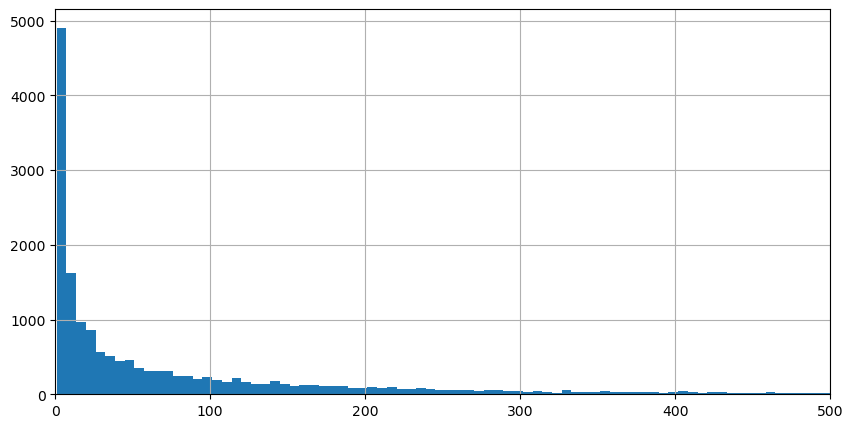

In [389]:
eda_hist_df["deposit"].hist(bins=800, figsize=(10, 5))
plt.xlim(0, 500)

# one-hot encoding

In [578]:
# cluster를 one-hot encoding
train_df = pd.get_dummies(train_df, columns=["cluster_100"])
test_df = pd.get_dummies(test_df, columns=["cluster_100"])

# contract_type을 one-hot encoding
train_df = pd.get_dummies(train_df, columns=["contract_type"])
test_df = pd.get_dummies(test_df, columns=["contract_type"])

total_columns = [c for c in train_df.columns if c not in ["deposit", "deposit_per_area"]]

# one-hot encoding시 값이 없으면 column이 생기지 않으므로,
# train 데이터셋과 test 데이터셋의 column을 맞춰줌
test_df = test_df.reindex(columns=total_columns, fill_value=0)
# train_df의 column의 dtype과 test_df의 column의 dtype이 다른 경우가 있음
# train_df의 column의 dtype을 기준으로 test_df의 column의 dtype을 변경
for column in test_df.columns:
    if test_df[column].dtype != train_df[column].dtype:
        print(column)
        test_df[column] = test_df[column].astype(train_df[column].dtype)

train_df.shape, test_df.shape

((1699120, 125), (150172, 123))

In [580]:
# 기존 test 데이터셋의 index로 정렬렬
test_df = test_df.sort_values(by="index").reset_index(drop=True)

# 필요없는 index 삭제
train_df.drop(columns=["index"], inplace=True)
test_df.drop(columns=["index"], inplace=True)

# Holdout 데이터셋 설정 (예: 2023년 7월부터 12월까지의 데이터)

In [583]:
holdout_start = 2023*365 + 7*30 + 1
holdout_end = 2023*365 + 12*30 + 1
holdout_data = train_df[(train_df['contract_year_month_date'] >= holdout_start) & (train_df['contract_year_month_date'] <= holdout_end)]
train_df = train_df[~((train_df['contract_year_month_date'] >= holdout_start) & (train_df['contract_year_month_date'] <= holdout_end))]

# 학습 데이터와 정답 데이터 분리

In [584]:
# target을 deposit_per_area로 변경
X_train = train_df.drop(columns=['deposit', 'deposit_per_area'])
deposit_per_area_train = train_df['deposit_per_area']
y_train = train_df['deposit']

X_holdout = holdout_data.drop(columns=['deposit', 'deposit_per_area'])
deposit_per_area_holdout = holdout_data['deposit_per_area']
y_holdout = holdout_data['deposit']

# LightGBM 모델 훈련

In [626]:
lgb_model = lgb.LGBMRegressor(
    random_state=RANDOM_SEED,
    num_leaves=33,
    n_estimators=500,
    early_stopping_rounds=50
)
# lgb_model.fit(X_train, deposit_per_area_train, eval_metric="mae", eval_set=[(X_holdout, deposit_per_area_holdout)])

# batch로 나눠서 학습
batch_num = 30
batch_size = len(X_train) // batch_num
for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = deposit_per_area_train[i:i+batch_size]
    # lgb_model.fit(X_batch, y_batch)
    lgb_model.fit(X_batch, y_batch, init_model=lgb_model if i != 0 else None, eval_metric="mae", eval_set=[(X_holdout, deposit_per_area_holdout)])

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3028
[LightGBM] [Info] Number of data points in the train set: 51070, number of used features: 116
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score 420.726515
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 69.6904	valid_0's l2: 13208.5
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing row-wise mul

# Holdout 데이터셋에 대한 성능 확인

In [627]:
lgb_holdout_pred = lgb_model.predict(X_holdout)
deposit_holdout_pred = lgb_holdout_pred * X_holdout['area_m2']
lgb_holdout_mae = mean_absolute_error(y_holdout, deposit_holdout_pred)
print("Holdout 데이터셋 성능:")
print(f"LightGBM MAE: {lgb_holdout_mae:.2f}")

Holdout 데이터셋 성능:
LightGBM MAE: 4051.11


Text(0.5, 1.0, 'Feature importance')

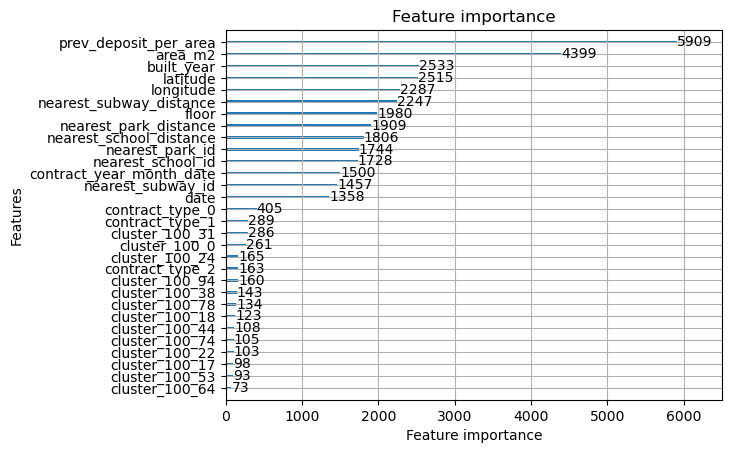

In [631]:
lgb.plot_importance(lgb_model, importance_type='split', max_num_features=30)
plt.title('Feature importance')

In [466]:
# prediction으로 eda
pred_df = X_holdout.copy()
pred_df['target'] = y_holdout
pred_df['pred'] = deposit_holdout_pred
pred_df['diff'] = np.abs(pred_df['target'] - pred_df['pred'])
# pred_df['contract_year_month_date'] = pd.to_datetime(pred_df['contract_year_month_date'], format='%Y%m%d')

KeyError: 'contract_year_month_day'

array([[<Axes: title={'center': 'area_m2'}>,
        <Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'floor'}>,
        <Axes: title={'center': 'built_year'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'nearest_subway_distance'}>,
        <Axes: title={'center': 'nearest_subway_id'}>,
        <Axes: title={'center': 'nearest_school_distance'}>],
       [<Axes: title={'center': 'nearest_school_id'}>,
        <Axes: title={'center': 'nearest_park_distance'}>,
        <Axes: title={'center': 'nearest_park_id'}>,
        <Axes: title={'center': 'interest_rate'}>,
        <Axes: title={'center': 'age_weight'}>],
       [<Axes: title={'center': 'prev_deposit_per_area'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'contract_year_month_date'}>,
        <Axes: title={'center': 'tar

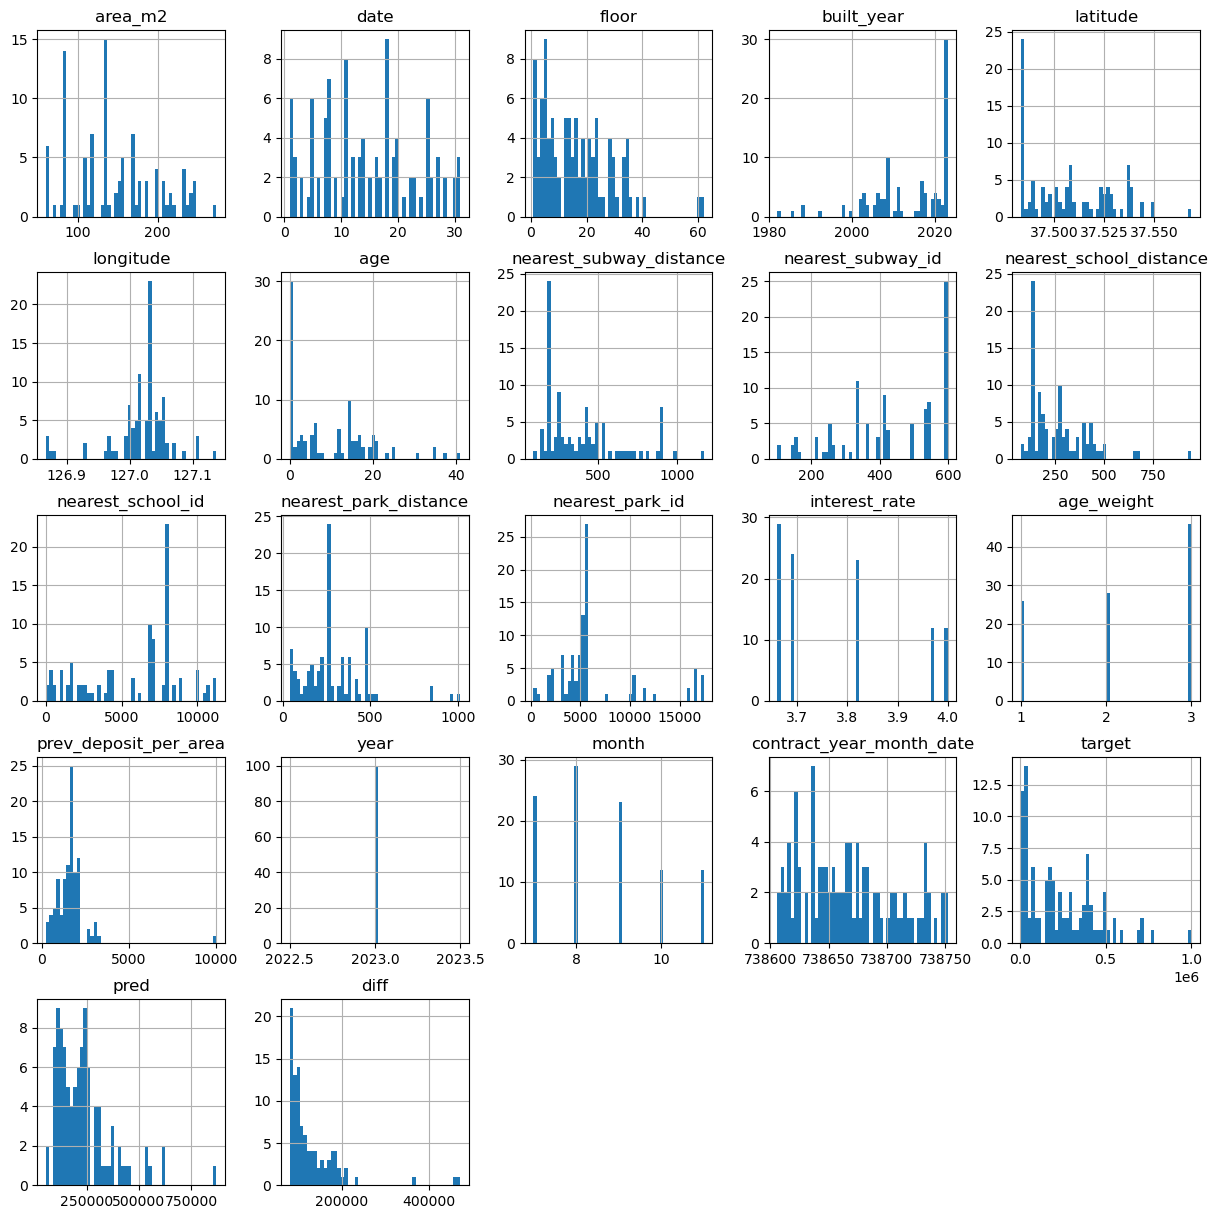

In [467]:
eda_df = pred_df.sort_values(by='diff', ascending=False).head(100)
eda_df.hist(bins=50, figsize=(15, 15))

In [629]:
pred_df = pd.DataFrame({'pred': deposit_holdout_pred, 'target': y_holdout})
pred_df["diff"] = pred_df["pred"] - pred_df["target"]
pred_df.describe()

,pred,target,diff
count,166994.000000,166994.000000,166994.000000
mean,40484.855096,40448.490419,36.364677
std,27338.012337,28415.319560,7504.109925
min,-2732.968994,955.000000,-467850.114969
25%,23161.295523,23000.000000,-2449.539113
50%,33851.183804,34000.000000,-11.698213
75%,49877.609677,50000.000000,2393.934765
max,790098.843812,1000000.000000,375992.021409


# Sample Submission 제출하기

In [633]:
# holdout 데이터셋도 학습에 사용
lgb_model.fit(X_holdout, deposit_per_area_holdout, init_model=lgb_model, eval_metric="mae", eval_set=[(X_holdout, deposit_per_area_holdout)])

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3131
[LightGBM] [Info] Number of data points in the train set: 166994, number of used features: 121
Training until validation scores don't improve for 50 rounds


LGBMRegressor(early_stopping_rounds=50, n_estimators=500, num_leaves=33,
              random_state=42)

In [634]:
lgb_test_pred = lgb_model.predict(test_df)

# 음수 예측값을 mean값으로 변경
# lgb_test_pred = np.where(lgb_test_pred < 0, lgb_test_pred.mean(), lgb_test_pred)
deposit_test_pred = lgb_test_pred * test_df['area_m2']
sample_submission['deposit'] = deposit_test_pred

In [636]:
index = datetime.datetime.now().strftime('%Y%m%d_%H%M')
sample_submission.to_csv(f'../../output/output_{index}_MAE_{lgb_holdout_mae:.2f}.csv', index=False, encoding='utf-8-sig')

# 기타: submission 분포 확인하기

In [635]:
sample_submission.describe()

,index,deposit
count,150172.00000,150172.000000
mean,75085.50000,39079.835896
std,43351.06665,24077.161411
min,0.00000,2216.519568
25%,37542.75000,23381.136670
50%,75085.50000,33842.241539
75%,112628.25000,48524.978058
max,150171.00000,743445.752796
